# Res-net model

In [1]:
# ==== Standard Libraries ====
import os, time, warnings

# ==== Scientific & Data Handling ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== PyTorch Core ====
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
from torchvision.models import resnet18

# ==== ML & Evaluation ====
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score
)
from sklearn.utils import resample
from statsmodels.stats.proportion import proportions_ztest

# ==== Utilities ====
from tqdm import tqdm

# ==== Reproducibility ====
SEED = 42

# ==== Device Handling (DirectML + fallback CPU) ====
try:
    import torch_directml
    DEVICE = torch_directml.device()
    print("Using DirectML device:", DEVICE)
except Exception as e:
    DEVICE = torch.device("cpu")
    print("DirectML no disponible. Usando CPU:", e)

# ==== Warnings ====
warnings.filterwarnings('ignore')

Using DirectML device: privateuseone:0


In [2]:
CSV_PATH = '../Data/Tabular.csv'
FOLDER_PATH = r"C:\Users\usuario\MRI\IMAGES_npy"

OUTPUT_DIR = "../Models_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# [] Atributos de las imégenes
shapes, means, stds, size = [], [], [], []

for f in os.listdir(FOLDER_PATH):
    if f.endswith(".npy"):
        img = np.load(os.path.join(FOLDER_PATH, f))
        shapes.append(img.shape)
        means.append(img.mean())
        stds.append(img.std())
        size.append(img.size)

# Contar shapes únicos
shapes_unicos = set(shapes)
size_unicos = set(size)
print("Shapes únicos encontrados:", shapes_unicos)
print("Total de imágenes:", len(shapes))
print(f"Media global promedio: {np.mean(means):.4f}")
print(f"Desviación global promedio: {np.mean(stds):.4f}")
print(f"Size únicos: {size_unicos}")

In [ ]:
# LOAD CSV
# ============================
df = pd.read_csv(CSV_PATH, dtype={'sujeto_id': str})
df = df.dropna(subset=['is_dementia'])

df['sujeto_id'] = df['sujeto_id'].astype(str).str.strip()
df['imagen_id'] = df['imagen_id'].astype(str).str.strip()

# FULL FILE PATH
def build_path(row):
    filename = f"{row['sujeto_id']}_{row['imagen_id']}.npy"
    return os.path.join(FOLDER_PATH, filename)

df['file_path'] = df.apply(build_path, axis=1)

df = df[['file_path', 'sujeto_id', 'is_dementia']].rename(
    columns={'is_dementia': 'label'}
)


In [ ]:
# 1. Distribución básica de is_dementia

class_distribution = df['label'].value_counts().sort_index()
print("=== DISTRIBUCIÓN DE CLASES ===")
print(f"Clase 0 (No Dementia): {class_distribution.get(0, 0)} imágenes - {class_distribution.get(0, 0)/len(df)*100:.2f}%")
print(f"Clase 1 (Dementia): {class_distribution.get(1, 0)} imágenes - {class_distribution.get(1, 0)/len(df)*100:.2f}%")
class_distribution = df['label'].value_counts().sort_index()
N = len(df)
count_dementia = class_distribution.get(1, 0)
expected_proportion = 0.5 
z_stat, p_value = proportions_ztest(count=count_dementia, 
                                    nobs=N, 
                                    value=expected_proportion, 
                                    alternative='two-sided')
print(f"Estadístico Z: {z_stat:.4f}")
print(f"Valor p: {p_value:.4e}")
# Conclusión
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusión: Se rechaza H0. La proporción de la Clase 1 ({count_dementia/N*100:.2f}%) es SIGNIFICATIVAMENTE diferente de {expected_proportion*100:.0f}%.")
else:
    print(f"\nConclusión: No se rechaza H0. No hay evidencia suficiente para decir que la proporción es diferente de {expected_proportion*100:.0f}%.")

=== DISTRIBUCIÓN DE CLASES ===
Clase 0 (No Dementia): 158 imágenes - 71.82%
Clase 1 (Dementia): 62 imágenes - 28.18%
Estadístico Z: -7.1933
Valor p: 6.3244e-13

Conclusión: Se rechaza H0. La proporción de la Clase 1 (28.18%) es SIGNIFICATIVAMENTE diferente de 50%.


In [ ]:
def group_stratified_split(records):
    """
    Split estratificado por SUJETO:
        Train 60%
        Val   20%
        Test  20%
    Sin fuga de información.
    """

    df_local = pd.DataFrame(records)

    # 1. Etiqueta por sujeto (promedio -> entero)
    subj_lab = df_local.groupby("sujeto_id")["label"].agg(lambda x: int(round(x.mean())))
    subjects = subj_lab.index.to_list()
    y = subj_lab.values

    # -----------------------------
    # 2. Train (60%) vs Resto (40%)
    # -----------------------------
    gss1 = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=SEED)
    train_idx, rest_idx = next(gss1.split(subjects, y, groups=subjects))

    train_subj = [subjects[i] for i in train_idx]
    rest_subj  = [subjects[i] for i in rest_idx]

    # -----------------------------
    # 3. Val (20%) vs Test (20%) dentro del 40%
    # -----------------------------
    rest_labels = [subj_lab[s] for s in rest_subj]

    val_subj, test_subj = train_test_split(
        rest_subj,
        test_size=0.5,
        random_state=SEED,
        stratify=rest_labels
    )

    # -----------------------------
    # 4. Regresar DataFrames
    # -----------------------------
    def pick(subjects_list):
        return df_local[df_local["sujeto_id"].isin(subjects_list)].reset_index(drop=True)

    return pick(train_subj), pick(val_subj), pick(test_subj)


In [ ]:
# [PASO 2] Construcción del DataSet MRI 2.5D
# ---------------------------

class MRI2p5DDataset(Dataset):
    def __init__(self, df, n_slices=32, target_size=(224,224), augment=False):
        """
        df: DataFrame con columnas 'file_path' y 'label'
        n_slices: número de cortes a tomar por volumen
        target_size: tamaño HxW de las imágenes
        augment: aplicar data augmentation
        """
        self.records = df.to_dict("records")
        self.n_slices = n_slices
        self.target_size = target_size
        self.augment = augment

        # Transforms
        self.augment_tf = T.Compose([
            T.RandomRotation(10),
            T.RandomResizedCrop(target_size, scale=(0.9,1.0))
        ])
        self.base_tf = T.Compose([
            T.Resize(target_size),
            T.ToTensor()
        ])
        
    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, idx):
        rec = self.records[idx]
        vol = np.load(rec["file_path"])  # (D,H,W) 3D array, Cortes-Altura-Ancho

        # Elegir n_slices uniformemente
        D = vol.shape[0]
        idxs = np.linspace(0, D-1, self.n_slices).astype(int)
        slices = vol[idxs]  # (n_slices,H,W)

        # Convertir cada slice a tensor
        imgs = []
        for s in slices:
            # Normalizar a [0,255] y convertir a PIL
            s_img = ((s - s.min())/(s.max()-s.min()+1e-6) * 255).astype(np.uint8)
            img = Image.fromarray(s_img).convert("L")  # 1 canal
            if self.augment:
                img = self.augment_tf(img)
            img = self.base_tf(img)  # (1,H,W)
            imgs.append(img)
        
        # Apilar slices como canales -> (n_slices,H,W)
        input_tensor = torch.cat(imgs, dim=0)
        
        label = torch.tensor(rec["label"], dtype=torch.float32)
        return input_tensor, label

In [ ]:
# [PASO 3] Modelo ResNet18 MRI 2.5D
# ---------------------------

class ResNet18_2p5D(nn.Module):
    """
    Modelo 2.5D basado en ResNet18 para clasificación binaria de volúmenes 3D (MRI). 
    
    Idea clave:
    - Cada volumen 3D se divide en 'n_slices' cortes (slices) uniformes.
    - Los slices se apilan como canales de una imagen 2D de entrada.
    - La ResNet18 procesa todos los slices simultáneamente como una "imagen 2D con n_slices canales".
    - La salida es un logit único por volumen, útil para predecir probabilidad de progresión de Alzheimer.

    Parámetros
    ----------
    n_slices : int
        Número de cortes (slices) que se apilan como canales de entrada.
        Por defecto: 32.
    """

    def __init__(self, n_slices=32):
        super().__init__()

        # Base ResNet18 sin pesos preentrenados
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(
            in_channels=n_slices,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512,1)
        )

    def forward(self, x):
        """
        Forward pass del modelo.

        Parámetros
        ----------
        x : torch.Tensor
            Tensor de entrada de forma (B, n_slices, H, W)
            donde B = batch size, n_slices = número de slices apilados,
            H y W = dimensiones espaciales de cada slice.

        Retorna
        -------
        logits : torch.Tensor
            Tensor de forma (B,), logit único por volumen.
            Este logit se puede pasar a sigmoid para obtener probabilidad.
        """
        # x: (B, n_slices, H, W)
        logits = self.model(x)  # ResNet18 produce (B,1)
        return logits.squeeze(1)  # Redimensiona a (B,)


In [ ]:
# [PASO 4] Entrenamiento por epoca y evaluacion
# ---------------------------

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()                    # Coloca el modelo en modo entrenamiento
    total_loss = 0
    total = 0
    pbar = tqdm(loader, desc="Train", leave=False)
    
    for X, y in pbar:
        X, y = X.to(device), y.to(device)  # Enviar batch a GPU/CPU
        optimizer.zero_grad()              # Reiniciar gradientes

        logits = model(X)                  # Forward
        loss = criterion(logits, y)        # Calcular pérdida
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Actualizar pesos

        total_loss += loss.item() * y.size(0)  # Acumular pérdida ponderada por batch
        total += y.size(0)
        pbar.set_postfix({"batch_loss": loss.item()})  # Mostrar pérdida por batch

    return total_loss / total  # Pérdida promedio por sample

def evaluate(model, val_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            logits = model(images)
            prob = torch.sigmoid(logits).cpu().numpy().flatten()
            pred = (prob >= 0.5).astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(pred)
            all_probs.extend(prob)

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    recall_pos = recall_score(all_labels, all_preds, pos_label=1)

    return acc, bal_acc, auc, recall_pos


In [ ]:
def prepare_dataloaders(df, batch_size, n_slices=32, target_size=(224,224)):
    records = df.to_dict("records")

    # -------- SPLIT POR SUJETO (60/20/20) --------
    train_df, val_df, test_df = group_stratified_split(records)

    print(f"Dimensiones: Train {len(train_df)} | Val {len(val_df)} | Test {len(test_df)}")

    # ========== CALCULAR CLASE PREDOMINANTE POR SUJETO ==========
    subj_lab = train_df.groupby("sujeto_id")["label"].agg(lambda x: int(round(x.mean())))

    #print("\n=== Etiqueta predominante por sujeto (Train) ===")
    #print(subj_lab.value_counts())

    # Sujetos mayoritarios/minoritarios según la etiqueta predominante
    maj_subj = subj_lab[subj_lab == 0].index.tolist()
    min_subj = subj_lab[subj_lab == 1].index.tolist()

    #print(f"Sujetos clase 0 (majority): {len(maj_subj)}")
    #print(f"Subjects clase 1 (minority): {len(min_subj)}")

    # ========== UPSAMPLING A NIVEL DE SUJETO ==========
    min_subj_upsampled = resample(
        min_subj,
        replace=True,
        n_samples=len(maj_subj),
        random_state=42
    )

    #print("\nSujetos repetidos en oversampling:")
    #print(pd.Series(min_subj_upsampled).value_counts())

    # ========== RECONSTRUIR TRAIN BALANCEADO SIN MODIFICAR VISITAS ==========
    train_df_bal = pd.concat([
        train_df[train_df["sujeto_id"].isin(maj_subj)],
        train_df[train_df["sujeto_id"].isin(min_subj_upsampled)]
    ]).sample(frac=1, random_state=42)

    print("\n=== Distribución después de oversampling (por imagen) ===")
    print(train_df_bal["label"].value_counts())

    # ========== DATASETS ==========
    train_dataset = MRI2p5DDataset(train_df_bal, n_slices=n_slices,
                                   target_size=target_size, augment=True)
    val_dataset   = MRI2p5DDataset(val_df, n_slices=n_slices,
                                   target_size=target_size, augment=False)
    test_dataset  = MRI2p5DDataset(test_df, n_slices=n_slices,
                                   target_size=target_size, augment=False)

    # ========== DATALOADERS ==========
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size)

    print(f"\nTrain Loader: {len(train_loader.dataset)} ejemplos, {len(train_loader)} batches")
    print(f"Validation Loader: {len(val_loader.dataset)} ejemplos, {len(val_loader)} batches")
    print(f"Test Loader: {len(test_loader.dataset)} ejemplos, {len(test_loader)} batches")

    return train_loader, val_loader, test_loader


In [ ]:
# [PASO 6] Modulo de entrenamiento
# ---------------------------
def train_model(
        model, train_loader, val_loader, device, 
        epochs, lr, weight_decay, early_stopping_patience, model_ej):
    """
    Entrena el modelo y retorna listas de pérdidas y métricas.
    """
    print(f"\n⏺️ Entrenando modelo: \nÉpocas {epochs} | LR-WD {lr}-{ weight_decay} | Patience {early_stopping_patience}")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    train_losses, val_recalls, val_aucs = [], [], []
    best_recall = 0
    patience_counter = 0

    print("▶️ Start train")
    time_all = time.time()

    for ep in range(epochs):
        time_ep = time.time()
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        time_train = time.time() - time_ep
        acc, bal_acc, auc, recall_pos = evaluate(model, val_loader, device)
        
        train_losses.append(train_loss)
        val_recalls.append(recall_pos)
        val_aucs.append(auc)

        print(f"Epoch {ep+1}/{epochs} | TrainLoss={train_loss:.4f} ||"
             f"VAcc={acc:.4f} | Recall_1={recall_pos:.4f} | "
              f"AUC={auc:.4f} | BalAcc={bal_acc:.4f} | "
              f"Time={time_train/60:.2f}")
        # Scheduler
        scheduler.step(train_loss)

        # EARLY STOPPING usando RECALL DE LA CLASE 1
        if recall_pos > best_recall:
            best_recall = recall_pos
            patience_counter = 0
            model_path = f"../Models_Output/{model_ej}_{epochs}_{ep}_{early_stopping_patience}.pth"
            torch.save(model.state_dict(), model_path)
            print(">> Mejor modelo guardado")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(">> Early stopping activado")
                break

    
    print(f"Tiempo total de entrenamiento: {(time.time() - time_all)/60:.2f} minutos")
    return train_losses, val_recalls, val_aucs, model_path

In [ ]:
def evaluate_final(model, test_loader, device, model_path):
    """
    Evalúa el mejor modelo guardado y calcula métricas relevantes,
    incluyendo sensibilidad (recall de clase positiva) y especificidad.
    """
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = (all_preds == all_labels).float().mean().item()
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    # Sensibilidad (recall clase positiva)
    sensitivity = recall_score(all_labels, all_preds, pos_label=1)

    # Especificidad (recall clase negativa)
    specificity = recall_score(all_labels, all_preds, pos_label=0)

    # F1 para la clase positiva (útil en clases desbalanceadas)
    f1_pos = f1_score(all_labels, all_preds, pos_label=1)

    print(f"\n===== RESULTADOS TEST =====")
    print(f"Acc = {acc:.4f}")
    print(f"Balanced Acc = {bal_acc:.4f}")
    print(f"AUC = {auc:.4f}")
    print(f"Sensitivity (Recall +) = {sensitivity:.4f}")
    print(f"Specificity (Recall -) = {specificity:.4f}")
    print(f"F1 Dementia = {f1_pos:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    print("\nMatriz de confusión:")
    print(cm)

    # Reporte de clasificación
    report = classification_report(all_labels, all_preds, target_names=["No Dementia", "Dementia"])
    print("\nReporte de clasificación:")
    print(report)

    return acc, bal_acc, auc, sensitivity, specificity, f1_pos, cm, report


In [ ]:
# ---------------------------
# MAIN
# ---------------------------
def main(df, device, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO):
    train_loader, val_loader, test_loader = prepare_dataloaders(df, BATCH)

    model = ResNet18_2p5D(n_slices=32).to(device)
    
    train_losses, val_recalls, val_aucs, model_path = train_model(
        model, train_loader, val_loader, device, 
        EPOCHS, LR, WEIGHT, EARLY, MODELO)
    
    # Curvas
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(val_recalls, label='Val Recall (Sensitivity)')
    plt.plot(val_aucs, label='Val AUC')
    plt.xlabel('Epoch'); plt.ylabel('Score'); plt.legend(); plt.grid(True)

    plt.show()
    
    # Evaluación final
    evaluate_final(model, test_loader, device, model_path)


-----------------

### 📊 Tabla organizada (menor → mayor capacidad)

| #  | epochs | lr    | weight_decay | patience | batch_size | “Capacidad” |
|----|--------|-------|--------------|----------|------------|------------------------------|
| 5  | 10     | 1e-3  | 0            | 3        | 2          | 20   |
| 1  | 20     | 1e-4  | 1e-5         | 5        | 4          | 80   |
| 8  | 20     | 1e-5  | 1e-4         | 7        | 4          | 80   |
| 3  | 20     | 1e-5  | 1e-6         | 5        | 8          | 160  |
| 2  | 30     | 5e-5  | 1e-5         | 7        | 4          | 120  |
| 10 | 30     | 1e-4  | 1e-6         | 5        | 8          | 240  |
| 7  | 30     | 1e-4  | 0            | 5        | 16         | 480  |
| 9  | 40     | 5e-5  | 1e-5         | 10       | 2          | 80   |
| 4  | 40     | 1e-4  | 1e-4         | 10       | 4          | 160  |
| 6  | 50     | 5e-5  | 1e-6         | 7        | 8          | 400  |



Dimensiones: Train 128 | Val 39 | Test 53

=== Etiqueta predominante por sujeto (Train) ===
label
0    22
1     8
Name: count, dtype: int64
Sujetos clase 0 (majority): 22
Subjects clase 1 (minority): 8

Sujetos repetidos en oversampling:
035_S_0204    5
023_S_0042    5
099_S_0054    4
136_S_0195    4
027_S_0256    2
021_S_0141    1
067_S_0077    1
Name: count, dtype: int64

=== Distribución después de oversampling (por imagen) ===
label
0    80
1    42
Name: count, dtype: int64

Train Loader: 122 ejemplos, 61 batches
Validation Loader: 39 ejemplos, 20 batches
Test Loader: 53 ejemplos, 27 batches

⏺️ Entrenando modelo: 
Épocas 10 | LR-WD 0.001-0 | Patience 3
▶️ Start train


Epoch 1/10 | TrainLoss=0.8359 || Validation:  Acc=0.5897 | Balance=0.4293 | AUC=0.4448 || Time: 36.3
>> Mejor modelo guardado


Epoch 2/10 | TrainLoss=0.6471 || Validation:  Acc=0.5128 | Balance=0.6069 | AUC=0.4448 || Time: 36.6
>> Mejor modelo guardado


Epoch 3/10 | TrainLoss=0.7074 || Validation:  Acc=0.4359 | Balance=0.4569 | AUC=0.4897 || Time: 37.6


Epoch 4/10 | TrainLoss=0.6712 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5690 || Time: 37.5


Epoch 5/10 | TrainLoss=0.6736 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.4517 || Time: 37.0
>> Early stopping activado
Tiempo total de entrenamiento: 3.45 minutos


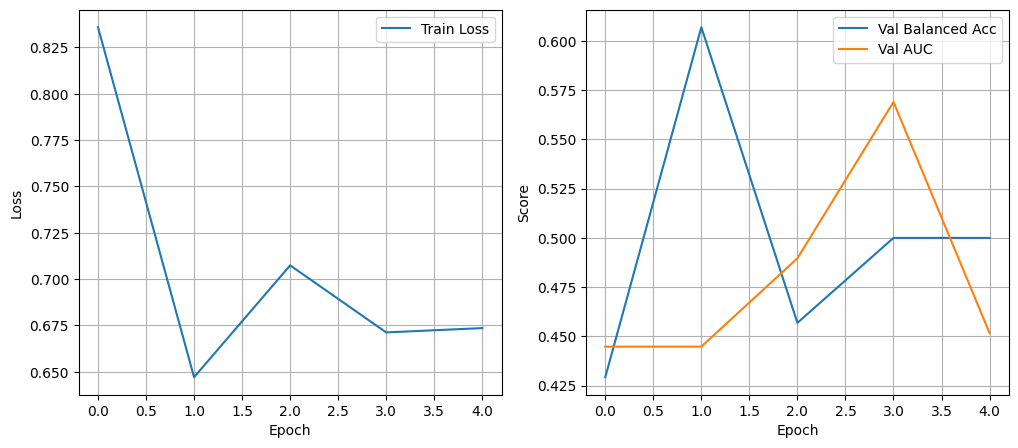

Test Acc=0.4528 | Test Balanced Acc=0.4292 | Test AUC=0.4292
Matriz de confusión:
[[22 26]
 [ 3  2]]
Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.88      0.46      0.60        48
    Dementia       0.07      0.40      0.12         5

    accuracy                           0.45        53
   macro avg       0.48      0.43      0.36        53
weighted avg       0.80      0.45      0.56        53



In [ ]:
# Ejecutar 1
# ---------------------------
MODELO = "Ejex_1"
EPOCHS = 10
LR = 1e-3
WEIGHT = 0
EARLY = 3
BATCH = 2
main(df, DEVICE, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

Dimensiones: Train 128 | Val 39 | Test 53

=== Distribución después de oversampling (por imagen) ===
label
0    80
1    42
Name: count, dtype: int64

Train Loader: 122 ejemplos, 31 batches
Validation Loader: 39 ejemplos, 10 batches
Test Loader: 53 ejemplos, 14 batches

⏺️ Entrenando modelo: 
Épocas 20 | LR-WD 0.0001-1e-05 | Patience 5
▶️ Start train


Epoch 1/20 | TrainLoss=0.6801 || Validation:  Acc=0.5128 | Balance=0.5741 | AUC=0.4724 || Time: 26.8
>> Mejor modelo guardado


Epoch 2/20 | TrainLoss=0.6246 || Validation:  Acc=0.4103 | Balance=0.4397 | AUC=0.3897 || Time: 26.2


Epoch 3/20 | TrainLoss=0.6093 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.4517 || Time: 25.8


Epoch 4/20 | TrainLoss=0.5200 || Validation:  Acc=0.4615 | Balance=0.3759 | AUC=0.4276 || Time: 25.6


Epoch 5/20 | TrainLoss=0.5246 || Validation:  Acc=0.4103 | Balance=0.5052 | AUC=0.4034 || Time: 25.8


Epoch 6/20 | TrainLoss=0.4684 || Validation:  Acc=0.4872 | Balance=0.3931 | AUC=0.3655 || Time: 25.2
>> Early stopping activado
Tiempo total de entrenamiento: 2.94 minutos


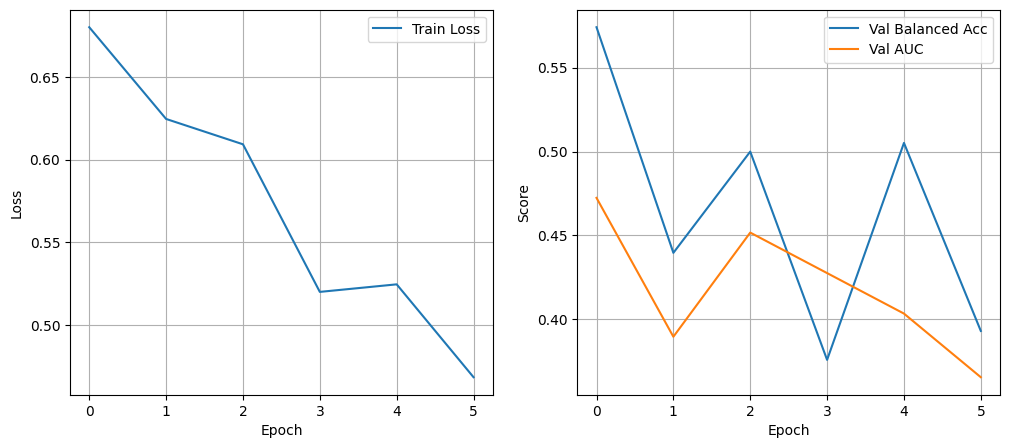

Test Acc=0.6226 | Test Balanced Acc=0.6125 | Test AUC=0.6125
Matriz de confusión:
[[30 18]
 [ 2  3]]
Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.94      0.62      0.75        48
    Dementia       0.14      0.60      0.23         5

    accuracy                           0.62        53
   macro avg       0.54      0.61      0.49        53
weighted avg       0.86      0.62      0.70        53



In [32]:
# Ejecutar 2
# ---------------------------
EPOCHS = 20 
LR = 1e-4
WEIGHT = 1e-5
EARLY = 5
BATCH = 4
main(df, DEVICE, EPOCHS, LR, WEIGHT, EARLY, BATCH)

Dimensiones: Train 128 | Val 39 | Test 53

=== Distribución después de oversampling (por imagen) ===
label
0    80
1    42
Name: count, dtype: int64

Train Loader: 122 ejemplos, 31 batches
Validation Loader: 39 ejemplos, 10 batches
Test Loader: 53 ejemplos, 14 batches

⏺️ Entrenando modelo: 
Épocas 20 | LR-WD 1e-05-0.0001 | Patience 7
▶️ Start train


Epoch 1/20 | TrainLoss=0.7105 || Validation:  Acc=0.4615 | Balance=0.5397 | AUC=0.6034 || Time: 24.7
>> Mejor modelo guardado


Epoch 2/20 | TrainLoss=0.6587 || Validation:  Acc=0.4359 | Balance=0.4569 | AUC=0.5310 || Time: 25.0


Epoch 3/20 | TrainLoss=0.7075 || Validation:  Acc=0.5641 | Balance=0.5431 | AUC=0.5276 || Time: 25.6
>> Mejor modelo guardado


Epoch 4/20 | TrainLoss=0.6708 || Validation:  Acc=0.6667 | Balance=0.5793 | AUC=0.5483 || Time: 25.5
>> Mejor modelo guardado


Epoch 5/20 | TrainLoss=0.6887 || Validation:  Acc=0.6923 | Balance=0.4655 | AUC=0.5552 || Time: 25.5


Epoch 6/20 | TrainLoss=0.6452 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5414 || Time: 25.7


Epoch 7/20 | TrainLoss=0.6547 || Validation:  Acc=0.7179 | Balance=0.4828 | AUC=0.5483 || Time: 25.7


Epoch 8/20 | TrainLoss=0.6392 || Validation:  Acc=0.7179 | Balance=0.4828 | AUC=0.5172 || Time: 25.7


Epoch 9/20 | TrainLoss=0.6407 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5207 || Time: 25.8


Epoch 10/20 | TrainLoss=0.6073 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.4862 || Time: 26.0


Epoch 11/20 | TrainLoss=0.6100 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.4931 || Time: 153.7
>> Early stopping activado
Tiempo total de entrenamiento: 7.47 minutos


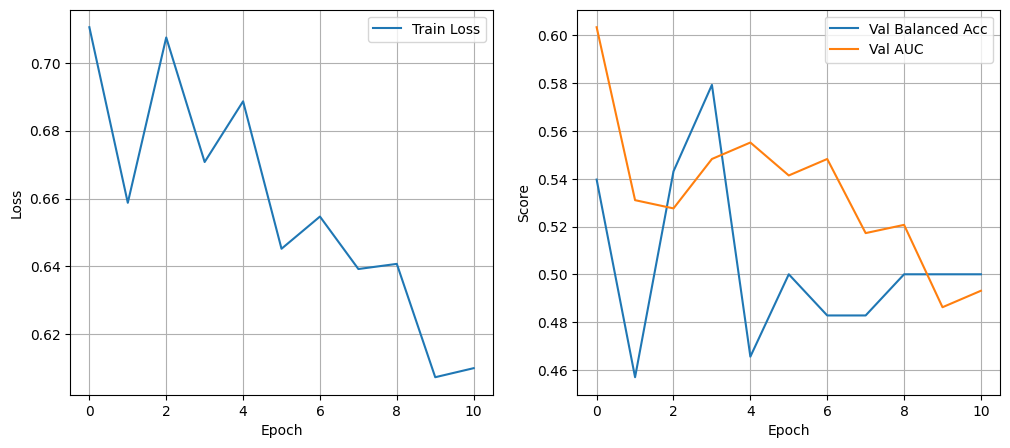

Test Acc=0.6415 | Test Balanced Acc=0.6229 | Test AUC=0.6229
Matriz de confusión:
[[31 17]
 [ 2  3]]
Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.94      0.65      0.77        48
    Dementia       0.15      0.60      0.24         5

    accuracy                           0.64        53
   macro avg       0.54      0.62      0.50        53
weighted avg       0.86      0.64      0.72        53



In [33]:
# Ejecutar 3
# ---------------------------
EPOCHS = 20 
LR = 1e-5
WEIGHT = 1e-4
EARLY = 7
BATCH = 4
main(df, DEVICE, EPOCHS, LR, WEIGHT, EARLY, BATCH)

Dimensiones: Train 128 | Val 39 | Test 53

=== Distribución después de oversampling (por imagen) ===
label
0    80
1    42
Name: count, dtype: int64

Train Loader: 122 ejemplos, 16 batches
Validation Loader: 39 ejemplos, 5 batches
Test Loader: 53 ejemplos, 7 batches

⏺️ Entrenando modelo: 
Épocas 20 | LR-WD 1e-05-1e-06 | Patience 5
▶️ Start train


Epoch 1/20 | TrainLoss=0.6622 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.4517 || Time: 19.6
>> Mejor modelo guardado


Epoch 2/20 | TrainLoss=0.6815 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.4000 || Time: 16.3


Epoch 3/20 | TrainLoss=0.6406 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5379 || Time: 16.7


Epoch 4/20 | TrainLoss=0.6620 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.6069 || Time: 20.1


Epoch 5/20 | TrainLoss=0.6555 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5931 || Time: 20.6


Epoch 6/20 | TrainLoss=0.6501 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5897 || Time: 20.0
>> Early stopping activado
Tiempo total de entrenamiento: 2.16 minutos


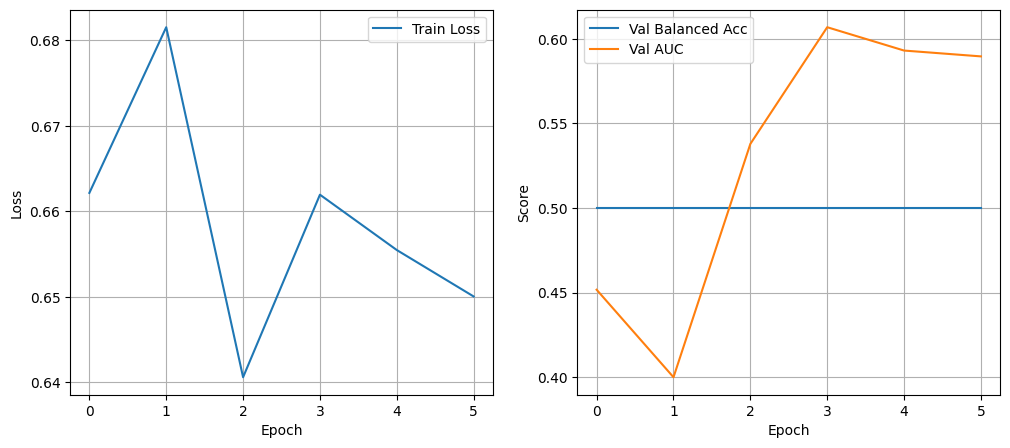

Test Acc=0.9057 | Test Balanced Acc=0.5000 | Test AUC=0.5000
Matriz de confusión:
[[48  0]
 [ 5  0]]
Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53



In [34]:
# Ejecutar 4
# ---------------------------
EPOCHS = 20 
LR = 1e-5
WEIGHT = 1e-6
EARLY = 5
BATCH = 8
main(df, DEVICE, EPOCHS, LR, WEIGHT, EARLY, BATCH)

Dimensiones: Train 128 | Val 39 | Test 53

=== Distribución después de oversampling (por imagen) ===
label
0    80
1    42
Name: count, dtype: int64

Train Loader: 122 ejemplos, 31 batches
Validation Loader: 39 ejemplos, 10 batches
Test Loader: 53 ejemplos, 14 batches

⏺️ Entrenando modelo: 
Épocas 30 | LR-WD 5e-05-1e-05 | Patience 7
▶️ Start train


Epoch 1/30 | TrainLoss=0.7000 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5690 || Time: 26.1
>> Mejor modelo guardado


Epoch 2/30 | TrainLoss=0.6736 || Validation:  Acc=0.5385 | Balance=0.5259 | AUC=0.4759 || Time: 25.7
>> Mejor modelo guardado


Epoch 3/30 | TrainLoss=0.6449 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5069 || Time: 25.6


Epoch 4/30 | TrainLoss=0.6411 || Validation:  Acc=0.7436 | Balance=0.5000 | AUC=0.5655 || Time: 25.7


Epoch 5/30 | TrainLoss=0.5928 || Validation:  Acc=0.7179 | Balance=0.4828 | AUC=0.5483 || Time: 25.8


Epoch 6/30 | TrainLoss=0.5646 || Validation:  Acc=0.5385 | Balance=0.4276 | AUC=0.4345 || Time: 27.6


Epoch 7/30 | TrainLoss=0.5892 || Validation:  Acc=0.7436 | Balance=0.5328 | AUC=0.4310 || Time: 26.9
>> Mejor modelo guardado


Epoch 8/30 | TrainLoss=0.5474 || Validation:  Acc=0.2821 | Balance=0.4517 | AUC=0.4655 || Time: 26.3


Epoch 9/30 | TrainLoss=0.4329 || Validation:  Acc=0.6923 | Balance=0.5310 | AUC=0.5069 || Time: 27.4


Epoch 10/30 | TrainLoss=0.4076 || Validation:  Acc=0.4872 | Balance=0.6224 | AUC=0.5414 || Time: 29.7
>> Mejor modelo guardado


Epoch 11/30 | TrainLoss=0.4914 || Validation:  Acc=0.6410 | Balance=0.5293 | AUC=0.4241 || Time: 26.0


Epoch 12/30 | TrainLoss=0.3343 || Validation:  Acc=0.7436 | Balance=0.5328 | AUC=0.4655 || Time: 25.9


Epoch 13/30 | TrainLoss=0.3496 || Validation:  Acc=0.5128 | Balance=0.4759 | AUC=0.3897 || Time: 25.8


Epoch 14/30 | TrainLoss=0.4120 || Validation:  Acc=0.4103 | Balance=0.4069 | AUC=0.4310 || Time: 25.3


Epoch 15/30 | TrainLoss=0.3687 || Validation:  Acc=0.7179 | Balance=0.5810 | AUC=0.4897 || Time: 25.2


Epoch 16/30 | TrainLoss=0.3652 || Validation:  Acc=0.5641 | Balance=0.4776 | AUC=0.4828 || Time: 25.3


Epoch 17/30 | TrainLoss=0.3230 || Validation:  Acc=0.5897 | Balance=0.5276 | AUC=0.4966 || Time: 30.1
>> Early stopping activado
Tiempo total de entrenamiento: 8.54 minutos


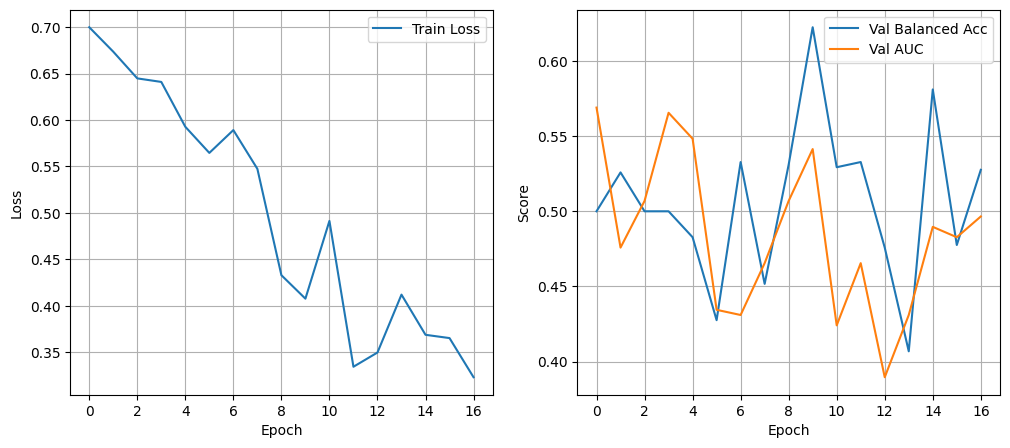

Test Acc=0.3396 | Test Balanced Acc=0.5458 | Test AUC=0.5458
Matriz de confusión:
[[14 34]
 [ 1  4]]
Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.93      0.29      0.44        48
    Dementia       0.11      0.80      0.19         5

    accuracy                           0.34        53
   macro avg       0.52      0.55      0.32        53
weighted avg       0.86      0.34      0.42        53



In [35]:
# Ejecutar 5
# ---------------------------
EPOCHS = 30
LR = 5e-5
WEIGHT = 1e-5
EARLY = 7
BATCH = 4
main(df, DEVICE, EPOCHS, LR, WEIGHT, EARLY, BATCH)

In [ ]:
# Ejecutar 6
# ---------------------------


EPOCHS = 30
LR = 1e-4
WEIGHT = 1e-6
EARLY = 5
BATCH = 8
main(df, DEVICE, EPOCHS, LR, WEIGHT, EARLY, BATCH)
